In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from IPython.display import display

#I import all the libraries we need: pandas for data, seaborn and matplotlib for plotting,
# and scipy for statistical tests.

In [3]:
# Load and prepare the main dataset (e-commerce behavior)
df_ecom = pd.read_csv("Ecommerce_Consumer_Behavior_Analysis_Data.csv")
df_ecom["Time_of_Purchase"] = pd.to_datetime(df_ecom["Time_of_Purchase"])
# Select only numeric columns for aggregation
numeric_cols = df_ecom.select_dtypes(include="number").columns

# Group by week and take average of numeric values
df_weekly = df_ecom.groupby(pd.Grouper(key="Time_of_Purchase", freq="W"))[numeric_cols].mean().reset_index()

# This step gets our weekly purchase behavior ready.

In [11]:
df_ecom.head()
#Lets look first data

,Customer_ID,Age,Gender,Income_Level,Marital_Status,Education_Level,Occupation,Location,Purchase_Category,Purchase_Amount,...,Customer_Satisfaction,Engagement_with_Ads,Device_Used_for_Shopping,Payment_Method,Time_of_Purchase,Discount_Used,Customer_Loyalty_Program_Member,Purchase_Intent,Shipping_Preference,Time_to_Decision
0,37-611-6911,22,Female,Middle,Married,Bachelor's,Middle,Évry,Gardening & Outdoors,$333.80,...,7,NaN,Tablet,Credit Card,2024-03-01,True,False,Need-based,No Preference,2
1,29-392-9296,49,Male,High,Married,High School,High,Huocheng,Food & Beverages,$222.22,...,5,High,Tablet,PayPal,2024-04-16,True,False,Wants-based,Standard,6
2,84-649-5117,24,Female,Middle,Single,Master's,High,Huzhen,Office Supplies,$426.22,...,7,Low,Smartphone,Debit Card,2024-03-15,True,True,Impulsive,No Preference,3
3,48-980-6078,29,Female,Middle,Single,Master's,Middle,Wiwilí,Home Appliances,$101.31,...,1,NaN,Smartphone,Other,2024-10-04,True,True,Need-based,Express,10
4,91-170-9072,33,Female,Middle,Widowed,High School,Middle,Nara,Furniture,$211.70,...,10,NaN,Smartphone,Debit Card,2024-01-30,False,False,Wants-based,No Preference,4


In [12]:
df_weekly.head()
#Lets look weekly data

,Time_of_Purchase,Age,Frequency_of_Purchase,Brand_Loyalty,Product_Rating,Time_Spent_on_Product_Research(hours),Return_Rate,Customer_Satisfaction,Time_to_Decision
0,2024-01-07,33.875000,8.312500,2.500000,2.625000,1.518750,0.625000,5.500000,8.625000
1,2024-01-14,31.947368,6.157895,2.578947,3.210526,0.694737,0.631579,5.210526,7.526316
2,2024-01-21,34.916667,7.166667,2.500000,3.250000,0.933333,1.083333,6.916667,8.000000
3,2024-01-28,37.619048,7.666667,3.523810,2.904762,0.904762,1.190476,4.809524,8.428571
4,2024-02-04,37.444444,6.222222,2.944444,3.333333,1.155556,1.111111,5.277778,6.944444


In [10]:
#Loop through 8 Google Trends files and calculate correlation
results = []

for i in range(1, 9):
    filename = f"multiTimeline-{i}.csv"

    try:
        df_trend = pd.read_csv(filename, skiprows=1)
        df_trend.rename(columns={df_trend.columns[0]: "date"}, inplace=True)
        df_trend["date"] = pd.to_datetime(df_trend["date"])

        category_name = df_trend.columns[1]  # Automatically get category name. There are lots of category in data, I check Google Trends data and according to it randomly select 8 category.

        for metric in ["Frequency_of_Purchase", "Customer_Satisfaction"]:
            df_merged = pd.merge(df_weekly, df_trend[["date", category_name]],
                                 left_on="Time_of_Purchase", right_on="date", how="inner")

            try:
              # I use pearsonr correlation test.
                corr, p = pearsonr(df_merged[category_name], df_merged[metric])
                results.append({
                    "Category": category_name,
                    "Metric": metric,
                    "Correlation (ρ)": round(corr, 3),
                    "p-value": round(p, 4),
                    "Significant?": "✅ Yes" if p < 0.05 else "❌ No"
                })
            except:
                results.append({
                    "Category": category_name,
                    "Metric": metric,
                    "Correlation (ρ)": "NA",
                    "p-value": "NA",
                    "Significant?": "⚠️ Error"
                })

    except Exception as e:
        print(f" {filename} | Error: {e}")

#I now have a correlation summary for all 8 categories and 2 metrics.

df_results = pd.DataFrame(results)
display(df_results.style.background_gradient(cmap="RdYlGn", subset=["Correlation (ρ)"]))

#This table shows the correlation results with colors.
#This table shows that we fail to reject the null hypothesis (H₀), as the p-values from Pearson's correlation tests are mostly greater than 0.05. Therefore, we can conclude that the correlations are not statistically significant.

,Category,Metric,Correlation (ρ),p-value,Significant?
0,Clothing: (Dünya Genelinde),Frequency_of_Purchase,-0.172000,0.222400,❌ No
1,Clothing: (Dünya Genelinde),Customer_Satisfaction,-0.285000,0.040600,✅ Yes
2,Furniture: (Dünya Genelinde),Frequency_of_Purchase,0.009000,0.949800,❌ No
3,Furniture: (Dünya Genelinde),Customer_Satisfaction,-0.213000,0.129800,❌ No
4,Baby Products: (Dünya Genelinde),Frequency_of_Purchase,0.001000,0.992100,❌ No
5,Baby Products: (Dünya Genelinde),Customer_Satisfaction,-0.040000,0.779600,❌ No
6,Electronics: (Dünya Genelinde),Frequency_of_Purchase,-0.169000,0.231500,❌ No
7,Electronics: (Dünya Genelinde),Customer_Satisfaction,-0.200000,0.155200,❌ No
8,Books: (Dünya Genelinde),Frequency_of_Purchase,-0.172000,0.221800,❌ No
9,Books: (Dünya Genelinde),Customer_Satisfaction,-0.182000,0.195500,❌ No


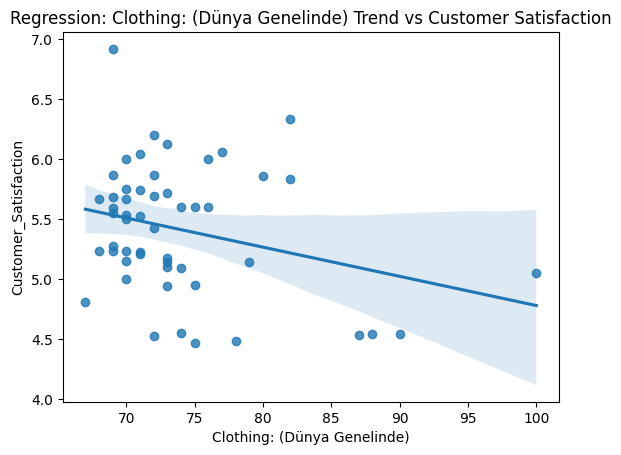

In [5]:
#Sample Output:Regression plot for Clothing (Customer Satisfaction)
example = pd.read_csv("multiTimeline-1.csv", skiprows=1)
example.rename(columns={example.columns[0]: "date"}, inplace=True)
example["date"] = pd.to_datetime(example["date"])
category = example.columns[1]
df_merge_example = pd.merge(df_weekly, example[["date", category]], left_on="Time_of_Purchase", right_on="date", how="inner")

sns.regplot(x=category, y="Customer_Satisfaction", data=df_merge_example)
plt.title(f"Regression: {category} Trend vs Customer Satisfaction")
plt.show()

# Linear regression between Clothing trend score and customer satisfaction.
# According to only this correlation we can reject to H0 however there is lots correlation too.

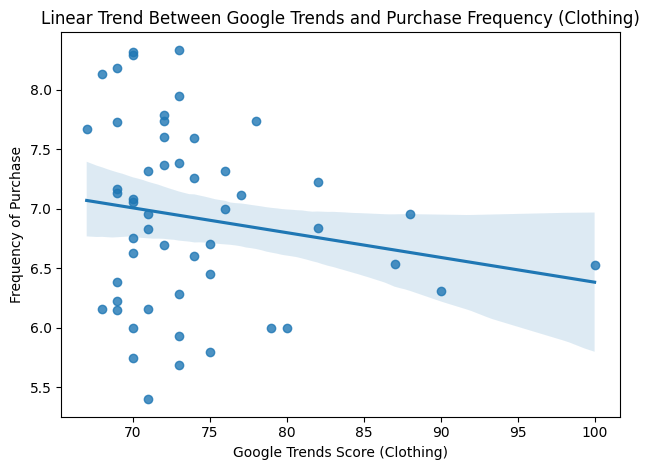

In [6]:
#Clothing - Trend vs Frequency

# Read Clothing again for specific metric comparison
df_clothing = pd.read_csv("multiTimeline-1.csv", skiprows=1)
df_clothing.rename(columns={df_clothing.columns[0]: "date"}, inplace=True)
df_clothing["date"] = pd.to_datetime(df_clothing["date"])
category_col = df_clothing.columns[1]

# Merge and plot
df_merged_clothing = pd.merge(df_weekly, df_clothing[["date", category_col]],
                              left_on="Time_of_Purchase", right_on="date", how="inner")

sns.regplot(x=category_col, y="Frequency_of_Purchase", data=df_merged_clothing)
plt.title("Linear Trend Between Google Trends and Purchase Frequency (Clothing)")
plt.xlabel("Google Trends Score (Clothing)")
plt.ylabel("Frequency of Purchase")
plt.tight_layout()
plt.show()

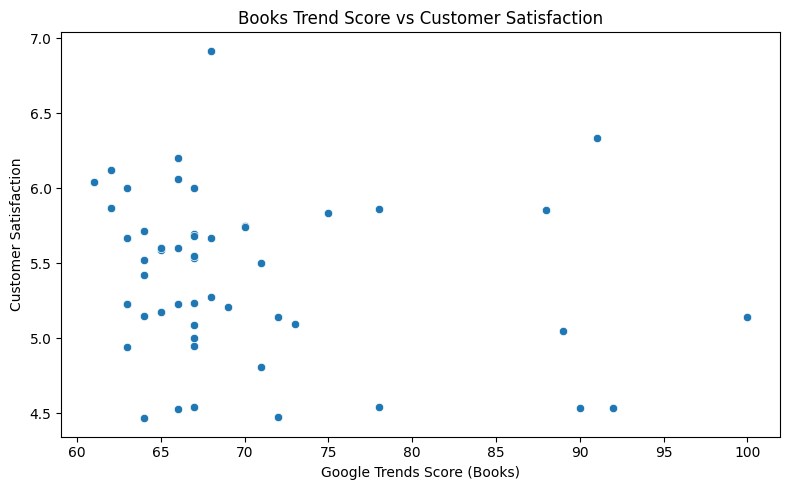

In [7]:
#Books - Trend vs Satisfaction (scatter plot only)
df_books = pd.read_csv("multiTimeline-5.csv", skiprows=1)
df_books.rename(columns={df_books.columns[0]: "date"}, inplace=True)
df_books["date"] = pd.to_datetime(df_books["date"])
category_col = df_books.columns[1]

df_merged_books = pd.merge(df_weekly, df_books[["date", category_col]],
                           left_on="Time_of_Purchase", right_on="date", how="inner")

plt.figure(figsize=(8, 5))
sns.scatterplot(x=category_col, y="Customer_Satisfaction", data=df_merged_books)
plt.title("Books Trend Score vs Customer Satisfaction")
plt.xlabel("Google Trends Score (Books)")
plt.ylabel("Customer Satisfaction")
plt.tight_layout()
plt.show()

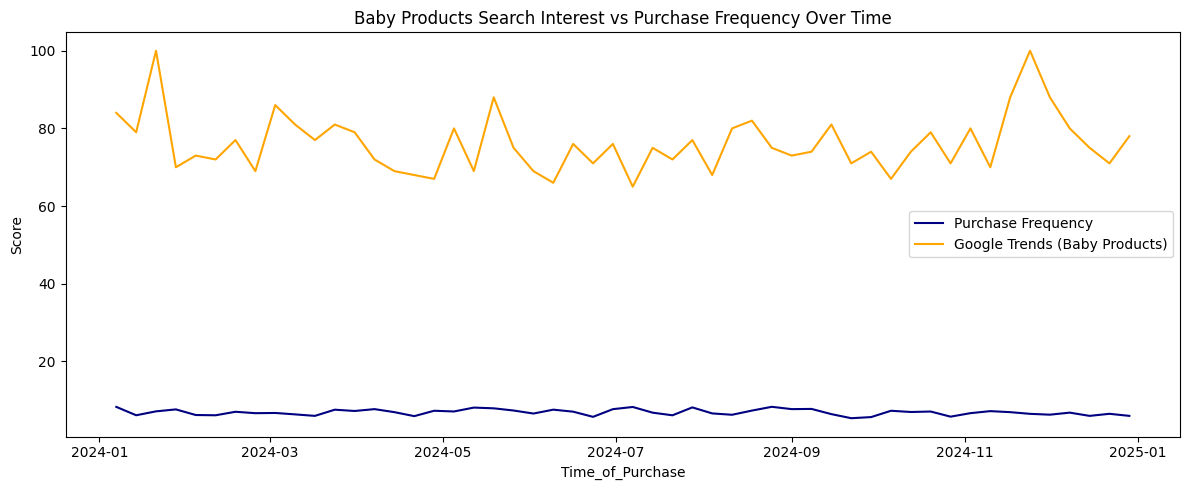

In [8]:
#Baby Products - Time Series

df_baby = pd.read_csv("multiTimeline-3.csv", skiprows=1)
df_baby.rename(columns={df_baby.columns[0]: "date"}, inplace=True)
df_baby["date"] = pd.to_datetime(df_baby["date"])
category_col = df_baby.columns[1]

df_merged_baby = pd.merge(df_weekly, df_baby[["date", category_col]],
                          left_on="Time_of_Purchase", right_on="date", how="inner")

plt.figure(figsize=(12, 5))
plt.plot(df_merged_baby['Time_of_Purchase'], df_merged_baby['Frequency_of_Purchase'], label='Purchase Frequency', color='navy')
plt.plot(df_merged_baby['Time_of_Purchase'], df_merged_baby[category_col], label='Google Trends (Baby Products)', color='orange')

plt.title("Baby Products Search Interest vs Purchase Frequency Over Time")
plt.xlabel("Time_of_Purchase")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.show()

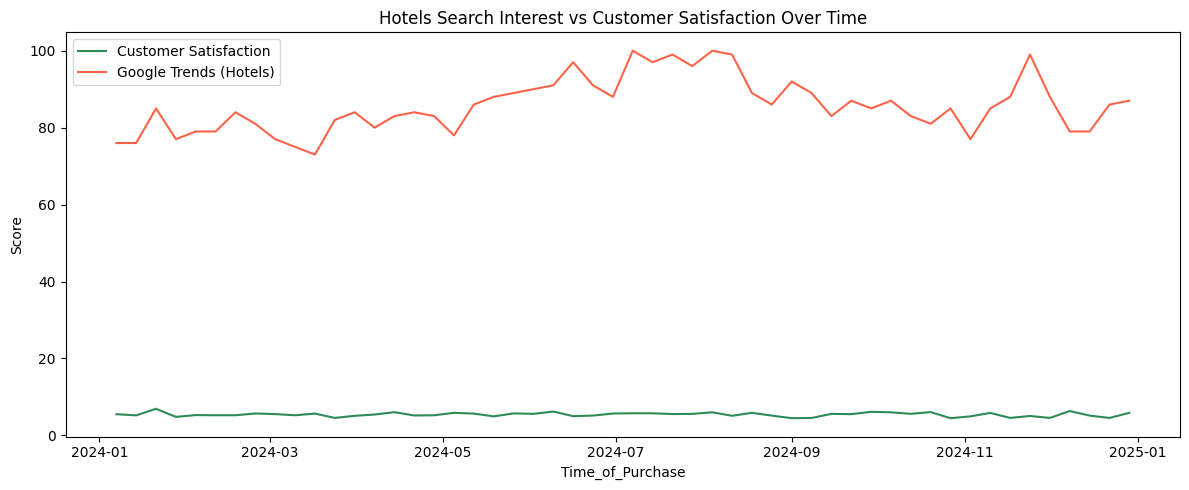

In [9]:
#Hotels - Time Series for Satisfaction
df_hotels = pd.read_csv("multiTimeline-7.csv", skiprows=1)
df_hotels.rename(columns={df_hotels.columns[0]: "date"}, inplace=True)
df_hotels["date"] = pd.to_datetime(df_hotels["date"])
category_col = df_hotels.columns[1]

df_merged_hotels = pd.merge(df_weekly, df_hotels[["date", category_col]],
                            left_on="Time_of_Purchase", right_on="date", how="inner")

plt.figure(figsize=(12, 5))
plt.plot(df_merged_hotels['Time_of_Purchase'], df_merged_hotels['Customer_Satisfaction'], label='Customer Satisfaction', color='seagreen')
plt.plot(df_merged_hotels['Time_of_Purchase'], df_merged_hotels[category_col], label='Google Trends (Hotels)', color='tomato')

plt.title("Hotels Search Interest vs Customer Satisfaction Over Time")
plt.xlabel("Time_of_Purchase")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.show()

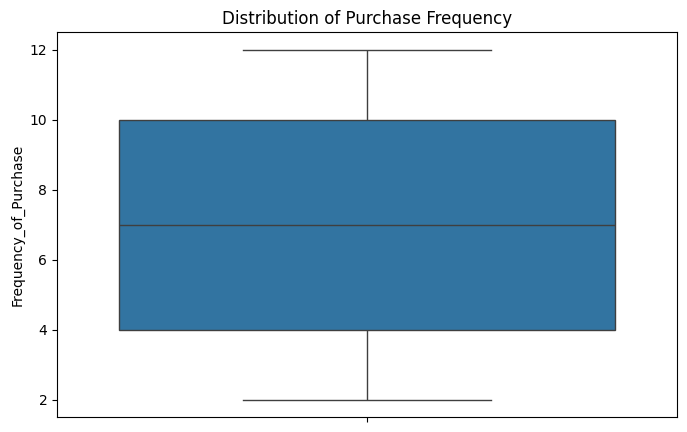

In [20]:
plt.figure(figsize=(8,5))
sns.boxplot(y='Frequency_of_Purchase', data=df_ecom)
plt.title("Distribution of Purchase Frequency")
plt.show()


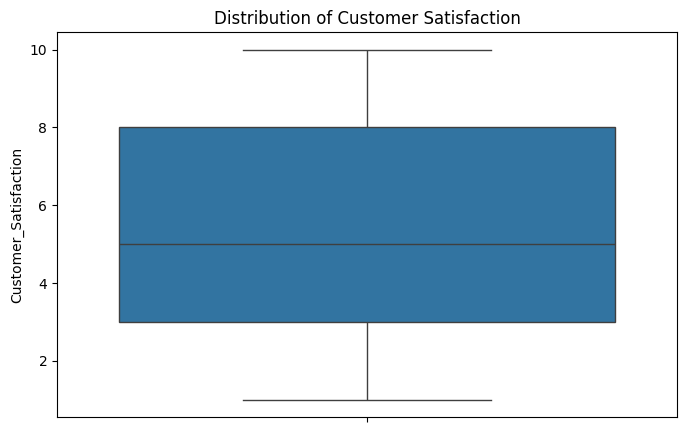

In [21]:
plt.figure(figsize=(8,5))
sns.boxplot(y='Customer_Satisfaction', data=df_ecom)
plt.title("Distribution of Customer Satisfaction")
plt.show()

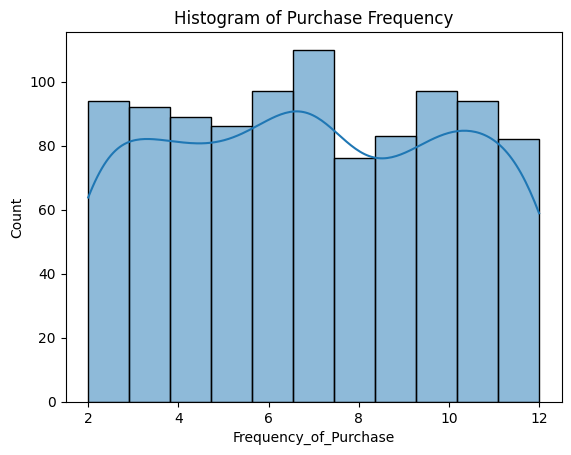

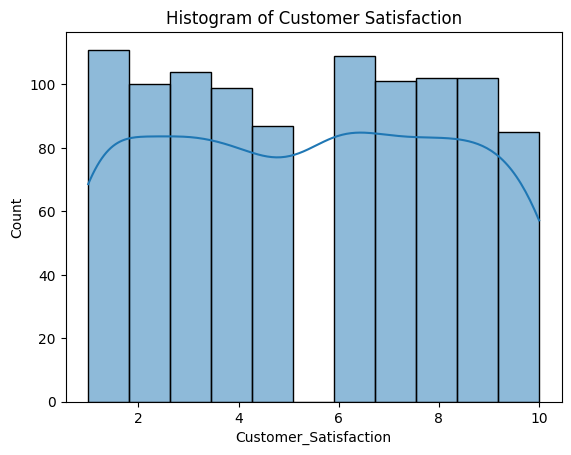

In [22]:
sns.histplot(df_ecom['Frequency_of_Purchase'], kde=True)
plt.title("Histogram of Purchase Frequency")
plt.show()

sns.histplot(df_ecom['Customer_Satisfaction'], kde=True)
plt.title("Histogram of Customer Satisfaction")
plt.show()

# Conclusion

## Which product categories show significant relationships between trend scores and consumer behavior?

Based on the Pearson correlation analysis and corresponding p-values, we **fail to reject the null hypothesis (H₀)** for most product categories and consumer behavior metrics.  
This means that there is **not enough statistical evidence** to support a significant linear relationship between Google Trends scores and consumer behavior (such as purchase frequency or customer satisfaction) in the majority of cases.

Only one correlation — between **Clothing** trends and **Customer Satisfaction** — was found to be statistically significant (*p* = 0.0406), with a **negative correlation** (ρ = -0.285).  
Although this is statistically significant, the strength of the correlation is still weak (|ρ| < 0.3), suggesting that while a trend exists, it is not particularly strong or predictive.  
This may imply that as online interest in clothing increases, customer satisfaction slightly decreases — possibly due to **higher expectations or increased competition**.

All other categories showed **non-significant correlations** (*p* > 0.05) with both frequency of purchase and satisfaction.  
This suggests that **Google Trends data alone is not a strong predictor** of consumer behavior across all product categories.

---

##  Which categories had the strongest correlations?

- **Strongest (and only significant) negative correlation**:  
  - *Clothing – Customer Satisfaction* (ρ = -0.285, *significant*)

- **Other notable (but non-significant) correlations**:  
  - *Luxury Goods – Frequency of Purchase* (ρ = -0.247)  
  - *Toys & Games – Frequency of Purchase* (ρ = -0.236)

Even though these are not statistically significant, they might reflect **underlying trends or seasonal effects** that merit further exploration.

---

## Surprising Results

Yes — despite **Baby Products** and **Furniture** having relatively stable and high search interest, they showed **almost no correlation** with actual purchase frequency or customer satisfaction.  
This may suggest that **consumers search for these categories without necessarily buying**, or that their purchase decisions are influenced by **offline or contextual factors** such as in-store availability, peer recommendations, or price sensitivity.


